# <a id='toc1_'></a>[LendingClub Machine Learning](#toc0_)

This is part 3 of the LendingClub machine learning project. If you haven't read part 2, I recommend reading that first. You can find it in the main folder of this repository with the filename: `Project Part 2.ipynb`.

In this part of the project, we'll focus on loan sub-grade classification and interest rate regression.

&nbsp;

## <a id='toc1_1_'></a>[What Is Sub Grade?](#toc0_)

According to [seven pillar institute](https://sevenpillarsinstitute.org/peer-to-peer-lending-lending-club/):

Credit ratings are a crucial part of this process. Loans are graded from A to G, where A is the highest grade and G is the lowest. In each letter class, the loans are assigned a subgrade between 1 and 5 where 5 is the lowest. A loan with a high grade enjoys a low interest rate and will cost the borrower less money. When deciding a loan’s grade, Lending Club will consider the borrower’s “credit score, credit history, desired loan amount and the borrower’s debt-to-income ratio”.


&nbsp;

**Table of contents**<a id='toc0_'></a>    
- [LendingClub Machine Learning](#toc1_)    
  - [What Is Sub Grade?](#toc1_1_)    
  - [Setup](#toc1_2_)    
    - [Installation and Imports](#toc1_2_1_)    
    - [Initial Setup](#toc1_2_2_)    
  - [Data Loading and First Exploration](#toc1_3_)    
  - [EDA: Exploratory Data Exploration](#toc1_4_)    
    - [Interest Rate](#toc1_4_1_)    
    - [Hardship Amount](#toc1_4_2_)    
    - [Original Projected Additional Accrued Interest](#toc1_4_3_)    
    - [Total Received Interest](#toc1_4_4_)    
    - [Balance To Credit Limit On All Trades](#toc1_4_5_)    
    - [Settlement Amount](#toc1_4_6_)    
    - [Current Balance vs Credit Limit](#toc1_4_7_)    
    - [Percentage of all bankcard accounts > 75% of limit](#toc1_4_8_)    
    - [Revolving Line Utilization Rate](#toc1_4_9_)    
    - [Second Applicant Revolving Line Utilization Rate](#toc1_4_10_)    
    - [Total Bankcard High Credit To Credit Limit](#toc1_4_11_)    
    - [Total Open To Buy On Revolving Bankcards.](#toc1_4_12_)    
    - [ FICO Range (Low) For The Secondary Applicant](#toc1_4_13_)    
    - [ FICO Range (Low)](#toc1_4_14_)    
    - [Sub Grade](#toc1_4_15_)    
  - [Data Preparation](#toc1_5_)    
  - [Machine Learning](#toc1_6_)    
    - [Interest Rate](#toc1_6_1_)    
  - [Deployment](#toc1_7_)    
  - [Summary](#toc1_8_)    
  - [Improvements](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


---

## <a id='toc1_2_'></a>[Setup](#toc0_)

This section contains the installation of required packages, importing them into the project and initial setup.

### <a id='toc1_2_1_'></a>[Installation and Imports](#toc0_)

In [14]:
%pip install --upgrade pip
%pip install -q -r src/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import dask.dataframe as dd
import src.lib.functions as f
import pprint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score
import optuna
import joblib
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from IPython.display import display
import requests
import json

### <a id='toc1_2_2_'></a>[Initial Setup](#toc0_)

In [16]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 80
logger = f.get_logger()
pp = pprint.PrettyPrinter(indent=4, width=120)
pd.set_option('display.max_columns', None)

&nbsp;

---

## <a id='toc1_3_'></a>[Data Loading and First Exploration](#toc0_)

In [17]:
run_data_cells = True
if run_data_cells:
    df_accepted = pd.read_csv("src/data/accepted_2007_to_2018Q4.csv", low_memory=False)
    display(df_accepted.head())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

Before starting the EDA, let's take a look at which features correlate with the grade and start creating a selection of features to explore during EDA.

In [18]:
if run_data_cells:
    le = LabelEncoder()
    df_accepted.dropna(subset=["sub_grade"], inplace=True)
    df_accepted["sub_grade_le"] = le.fit_transform(df_accepted["sub_grade"])
    corrs = (
        df_accepted.sample(1_000_000)
        .select_dtypes(include=np.number)
        .corr()["sub_grade_le"]
    )
    meaningfull_corrs = corrs.loc[(corrs > 0.25) | (corrs < -0.25)].sort_values(
        ascending=False
    )
    print(meaningfull_corrs)

sub_grade_le                                  1.000000
int_rate                                      0.976620
hardship_amount                               0.570983
orig_projected_additional_accrued_interest    0.563329
total_rec_int                                 0.452388
settlement_amount                             0.312572
all_util                                      0.310423
bc_util                                       0.293827
percent_bc_gt_75                              0.287981
revol_util                                    0.277454
sec_app_revol_util                            0.265090
total_bc_limit                               -0.252900
last_fico_range_low                          -0.294279
bc_open_to_buy                               -0.312834
last_fico_range_high                         -0.372717
sec_app_fico_range_low                       -0.382498
sec_app_fico_range_high                      -0.382498
fico_range_high                              -0.438042
fico_range

Let's see how many null values are present in each of these columns.

In [19]:
if run_data_cells:
    print(df_accepted[meaningfull_corrs.index].isna().sum() / df_accepted.shape[0])

sub_grade_le                                  0.000000
int_rate                                      0.000000
hardship_amount                               0.995171
orig_projected_additional_accrued_interest    0.996173
total_rec_int                                 0.000000
settlement_amount                             0.984851
all_util                                      0.383227
bc_util                                       0.033650
percent_bc_gt_75                              0.033344
revol_util                                    0.000797
sec_app_revol_util                            0.953030
total_bc_limit                                0.022131
last_fico_range_low                           0.000000
bc_open_to_buy                                0.033147
last_fico_range_high                          0.000000
sec_app_fico_range_low                        0.952217
sec_app_fico_range_high                       0.952217
fico_range_high                               0.000000
fico_range

There's quite a few features with a lot of NaN values just as we saw in part 2, with the same explanation for most of them.

&nbsp;

## <a id='toc1_4_'></a>[EDA: Exploratory Data Exploration](#toc0_)

Let's explore the features we identified above. Just like in part 2, I'm dropping the last and high FICO ranges.

In [20]:
if run_data_cells:
    df = df_accepted[meaningfull_corrs.index].copy()
    df["sub_grade"] = df_accepted["sub_grade"].copy()
    df.drop(
        [
            "last_fico_range_low",
            "last_fico_range_high",
            "sec_app_fico_range_high",
            "fico_range_high",
        ],
        axis=1,
        inplace=True,
    )
    df.to_parquet("src/data/df_part_3.parquet")
else:
    df = pd.read_parquet("src/data/df_part_3.parquet")

An important thing to notice in these plots, is that I'm not using a hue for each plot, because the plots become unreadable due to the fact that there are 35 different sub grades in the dataset.

&nbsp;

### <a id='toc1_4_1_'></a>[Interest Rate](#toc0_)

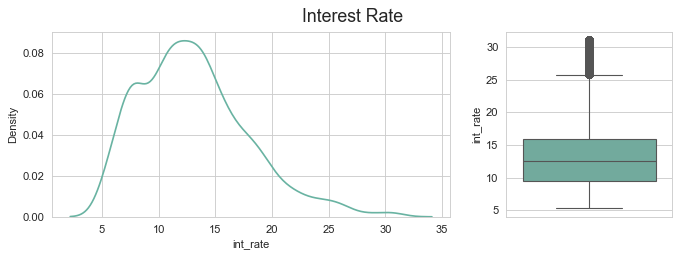

In [21]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "int_rate",
    title="Interest Rate",
    bw_adjust=4,
    figsize=(10, 3),
);

The mean interest hovers around 12%, with outliers starting around 25%.

&nbsp;

### <a id='toc1_4_2_'></a>[Hardship Amount](#toc0_)

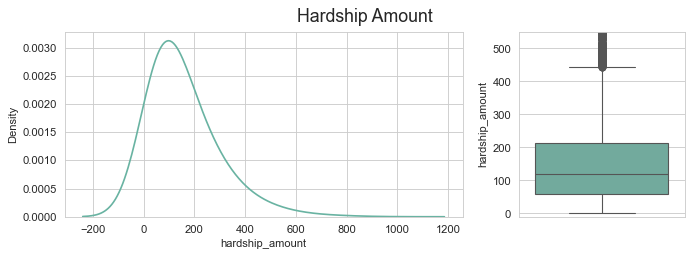

In [22]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "hardship_amount",
    title="Hardship Amount",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 550]);

The mean for hardship amount hovers around 100k with outliers all the way up to roughly 900k.

&nbsp;

### <a id='toc1_4_3_'></a>[Original Projected Additional Accrued Interest](#toc0_)

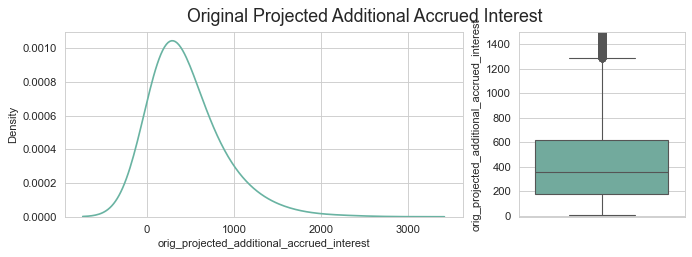

In [23]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "orig_projected_additional_accrued_interest",
    title="Original Projected Additional Accrued Interest",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 1500]);

&nbsp;

### <a id='toc1_4_4_'></a>[Total Received Interest](#toc0_)

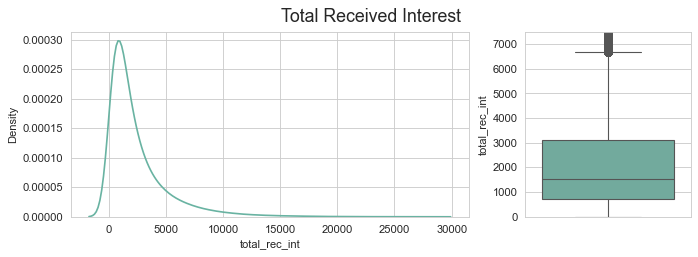

In [24]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "total_rec_int",
    title="Total Received Interest",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 7500]);

### <a id='toc1_4_5_'></a>[Balance To Credit Limit On All Trades](#toc0_)

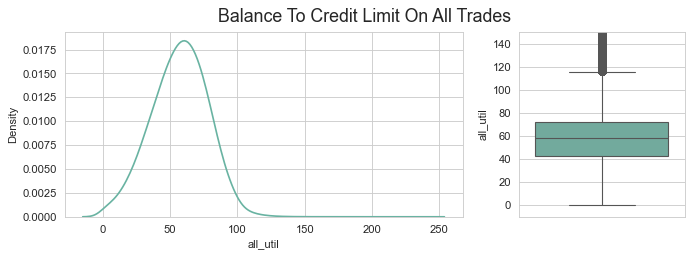

In [25]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "all_util",
    title="Balance To Credit Limit On All Trades",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 150]);

### <a id='toc1_4_6_'></a>[Settlement Amount](#toc0_)

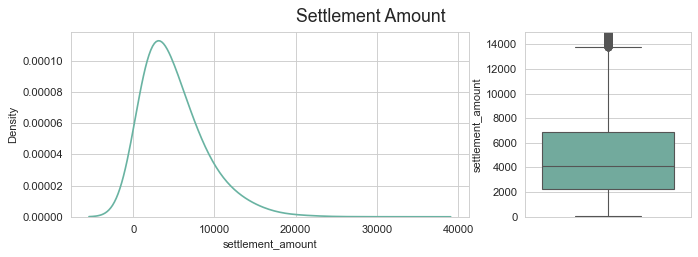

In [26]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "settlement_amount",
    title="Settlement Amount",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 15000]);

### <a id='toc1_4_7_'></a>[Current Balance vs Credit Limit](#toc0_)
Ratio of total current balance to high credit/credit limit for all bankcard accounts.

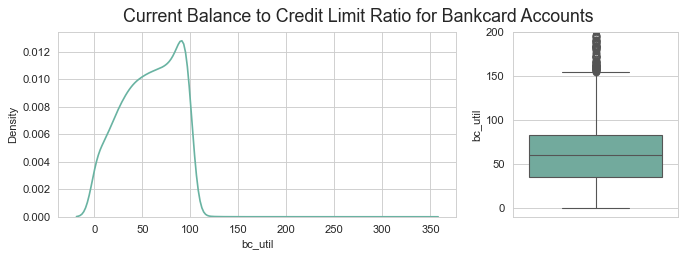

In [27]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "bc_util",
    title="Current Balance to Credit Limit Ratio for Bankcard Accounts",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 200]);

### <a id='toc1_4_8_'></a>[Percentage of all bankcard accounts > 75% of limit](#toc0_)

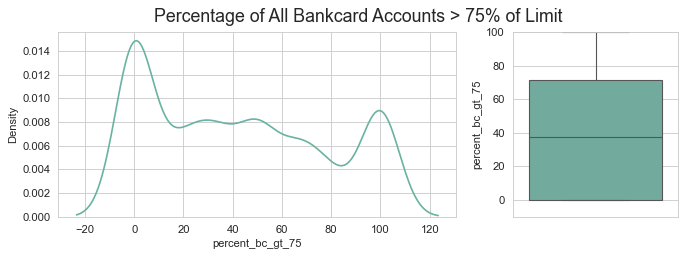

In [28]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "percent_bc_gt_75",
    title="Percentage of All Bankcard Accounts > 75% of Limit",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 100]);

### <a id='toc1_4_9_'></a>[Revolving Line Utilization Rate](#toc0_)

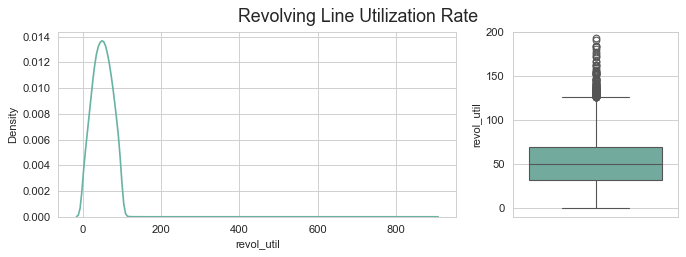

In [29]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "revol_util",
    title="Revolving Line Utilization Rate",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 200]);

### <a id='toc1_4_10_'></a>[Second Applicant Revolving Line Utilization Rate](#toc0_)

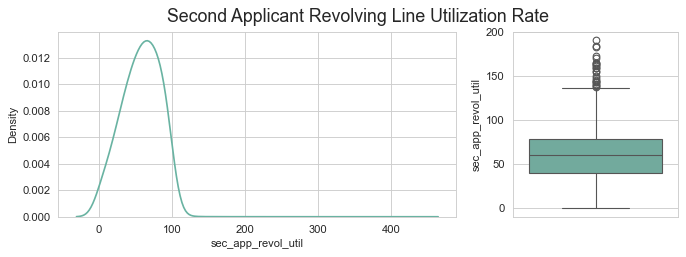

In [30]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "sec_app_revol_util",
    title="Second Applicant Revolving Line Utilization Rate",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-10, 200]);

### <a id='toc1_4_11_'></a>[Total Bankcard High Credit To Credit Limit](#toc0_)

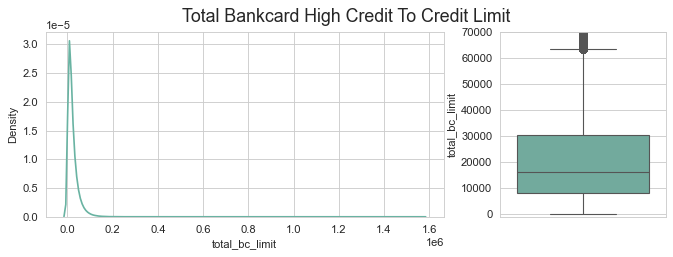

In [31]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "total_bc_limit",
    title="Total Bankcard High Credit To Credit Limit",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([ -1e3, .7e5]);

### <a id='toc1_4_12_'></a>[Total Open To Buy On Revolving Bankcards.](#toc0_)

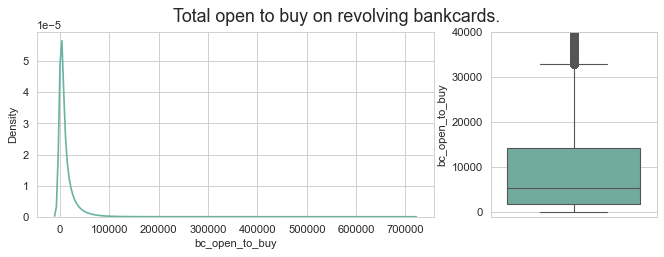

In [32]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "bc_open_to_buy",
    title="Total open to buy on revolving bankcards.",
    bw_adjust=4,
    figsize=(10, 3),
)
plt.gca().set_ylim([-1e3, 0.4e5]);

### <a id='toc1_4_13_'></a>[ FICO Range (Low) For The Secondary Applicant](#toc0_)

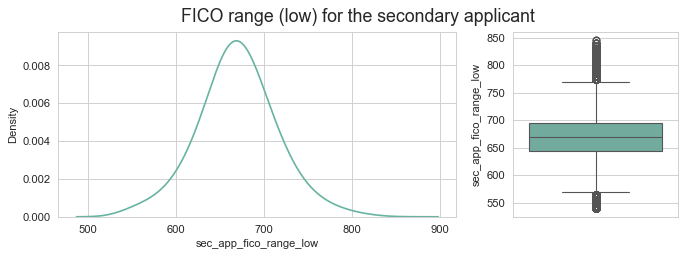

In [33]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "sec_app_fico_range_low",
    title="FICO range (low) for the secondary applicant",
    bw_adjust=4,
    figsize=(10, 3),
);

### <a id='toc1_4_14_'></a>[ FICO Range (Low)](#toc0_)

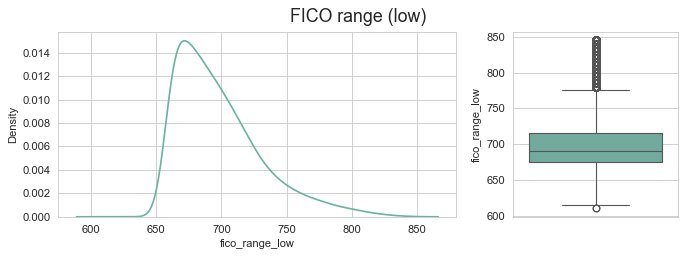

In [34]:
f.plot_kde_and_box(
    df.sort_values("sub_grade"),
    "fico_range_low",
    title="FICO range (low)",
    bw_adjust=4,
    figsize=(10, 3),
);

### <a id='toc1_4_15_'></a>[Sub Grade](#toc0_)

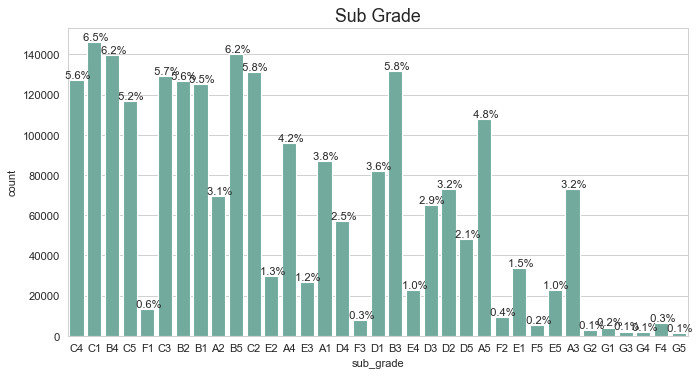

In [35]:
f.countplot(df, "sub_grade", title="Sub Grade", bar_labels=True);

&nbsp;

## <a id='toc1_5_'></a>[Data Preparation](#toc0_)

In [36]:
numerical_columns = df.select_dtypes(include=np.number).columns
categorical_columns = df.select_dtypes(include="object").columns
for col in numerical_columns:
    df[col].fillna(-1, inplace=True)

df.dropna(subset=["sub_grade"], inplace=True)
df.dropna(subset=["int_rate"], inplace=True)

le = LabelEncoder()
df["sub_grade_le"] = le.fit_transform(df["sub_grade"])
df.drop("sub_grade", axis=1, inplace=True)


Let's take a look at the data after the preparation step.

In [37]:
df.head()

,sub_grade_le,int_rate,hardship_amount,orig_projected_additional_accrued_interest,total_rec_int,settlement_amount,all_util,bc_util,percent_bc_gt_75,revol_util,sec_app_revol_util,total_bc_limit,bc_open_to_buy,sec_app_fico_range_low,fico_range_low
0,13,13.99,-1.0,-1.0,821.72,-1.0,34.0,37.2,0.0,29.7,-1.0,2400.0,1506.0,-1.0,675.0
1,10,11.99,-1.0,-1.0,979.66,-1.0,29.0,27.1,7.7,19.2,-1.0,79300.0,57830.0,-1.0,715.0
2,8,10.78,-1.0,-1.0,2705.92,-1.0,65.0,55.9,50.0,56.2,-1.0,6200.0,2737.0,-1.0,695.0
3,14,14.85,-1.0,-1.0,12361.66,-1.0,45.0,12.1,0.0,11.6,-1.0,62500.0,54962.0,-1.0,785.0
4,25,22.45,-1.0,-1.0,1340.50,-1.0,78.0,77.5,60.0,64.5,-1.0,20300.0,4567.0,-1.0,695.0


The final step before training any model is splitting the data into a training, validation and testing set.

In [38]:
sub_data = f.train_test_valid_split(
    data=df.drop(columns=["int_rate"]),
    label_column="sub_grade_le",
    stratify=["sub_grade_le"],
)
int_data = f.train_test_valid_split(
    data=df.drop(columns=["sub_grade_le"]), label_column="int_rate"
)


&nbsp;

## <a id='toc1_6_'></a>[Machine Learning](#toc0_)

Let's create a model and train it using optuna to optimize the hyperparameters.

In [39]:
sub_xgb_model_path = "src/models/p3_best_sub_xgb_model.joblib"

if not os.path.exists(sub_xgb_model_path):
    sub_xgb_study = optuna.create_study(direction="maximize")

    sub_xgb_study.optimize(
        lambda trial: f.xgb_classification_objective(
            trial,
            x_train=sub_data["x_train"],
            y_train=sub_data["y_train"],
            x_valid=sub_data["x_valid"],
            y_valid=sub_data["y_valid"],
        ),
        n_trials=30,
    )

if not os.path.exists(sub_xgb_model_path):
    sub_best_xgb_model = f.get_pipeline(
        XGBClassifier(**sub_xgb_study.best_params),
        numerical_columns=sub_data["x_train"].select_dtypes(include=np.number).columns,
    ).fit(sub_data["x_train"], sub_data["y_train"])
    joblib.dump(sub_best_xgb_model, sub_xgb_model_path)
else:
    sub_best_xgb_model = joblib.load(sub_xgb_model_path)

Let's take a look at the performance.

In [40]:
f.test_model(
    pred_train=sub_best_xgb_model.predict(sub_data["x_train"]),
    pred_test=sub_best_xgb_model.predict(sub_data["x_test"]),
    y_train=sub_data["y_train"],
    y_test=sub_data["y_test"],
    logger=logger,
)

2024-02-05 11:34:14,939 - root - INFO - Training scores:

2024-02-05 11:34:14,939 - root - INFO -     - Accuracy: 0.152
2024-02-05 11:34:14,940 - root - INFO -     - Precision: 0.153
2024-02-05 11:34:14,940 - root - INFO -     - Recall: 0.152
2024-02-05 11:34:15,214 - root - INFO - Test scores:

2024-02-05 11:34:15,214 - root - INFO -     - Accuracy: 0.116
2024-02-05 11:34:15,215 - root - INFO -     - Precision: 0.107
2024-02-05 11:34:15,215 - root - INFO -     - Recall: 0.116


Yikes, that's not looking too good. Let's look at the ROC curves.

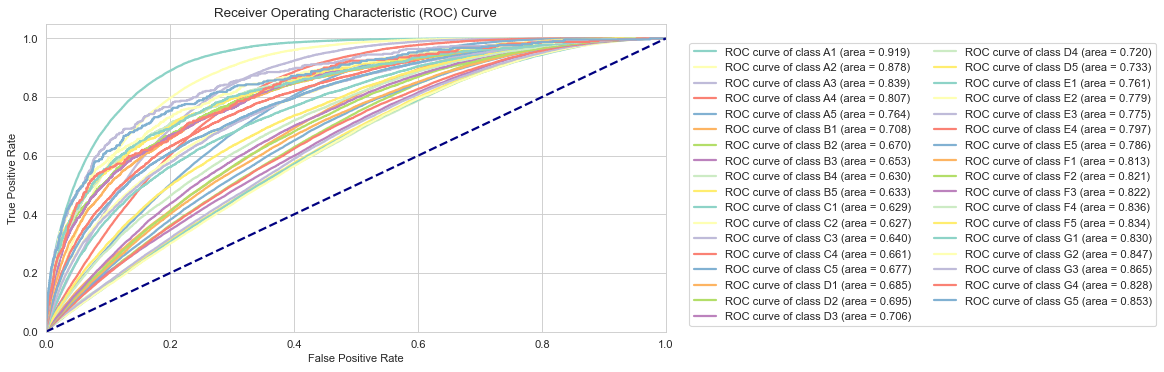

In [41]:
f.plot_multiclass_roc(
    sub_best_xgb_model,
    sub_data["x_test"],
    sub_data["y_test"],
    n_classes=df["sub_grade_le"].nunique(),
    class_labels=le.classes_,
    legend_params={"loc": "lower right", "ncol": 2, "bbox_to_anchor": (1.8, 0)},
)

Like in part 2, there's a big difference in the ROC curve for each class.

Let's see if we're able to get some better performance on the interest rate.

&nbsp;

### <a id='toc1_6_1_'></a>[Interest Rate](#toc0_)

In [42]:
int_xgb_model_path = "src/models/p3_best_int_xgb_model.joblib"
imp.reload(f)

if not os.path.exists(int_xgb_model_path):
    int_xgb_study = optuna.create_study(direction="minimize")

    int_xgb_study.optimize(
        lambda trial: f.xgb_regression_objective(
            trial,
            x_train=int_data["x_train"],
            y_train=int_data["y_train"],
            x_valid=int_data["x_valid"],
            y_valid=int_data["y_valid"],
        ),
        n_trials=30,
    )

    int_best_xgb_model = f.get_pipeline(
        XGBRegressor(**int_xgb_study.best_params),
        numerical_columns=int_data["x_train"].select_dtypes(include=np.number).columns,
    ).fit(int_data["x_train"], int_data["y_train"])
    joblib.dump(int_best_xgb_model, int_xgb_model_path)
else:
    int_best_xgb_model = joblib.load(int_xgb_model_path)

Let's test the model on some metrics.

In [43]:
f.test_regression_model(
    pred_train=int_best_xgb_model.predict(int_data["x_train"]),
    pred_test=int_best_xgb_model.predict(int_data["x_test"]),
    y_train=int_data["y_train"],
    y_test=int_data["y_test"],
    logger=logger,
)

2024-02-05 11:36:37,645 - root - INFO - Training scores:

2024-02-05 11:36:37,646 - root - INFO -     - Mean Absolute Percentage Error: 0.221
2024-02-05 11:36:37,646 - root - INFO -     - Explained Variance: 0.478
2024-02-05 11:36:37,647 - root - INFO -     - R2 Score: 0.478

2024-02-05 11:36:37,734 - root - INFO - Test scores:

2024-02-05 11:36:37,734 - root - INFO -     - Mean Absolute Percentage Error: 0.221
2024-02-05 11:36:37,735 - root - INFO -     - Explained Variance: 0.478
2024-02-05 11:36:37,735 - root - INFO -     - R2 Score: 0.478



Now finally, let's take a look at how the error is distributed across different interest rates.

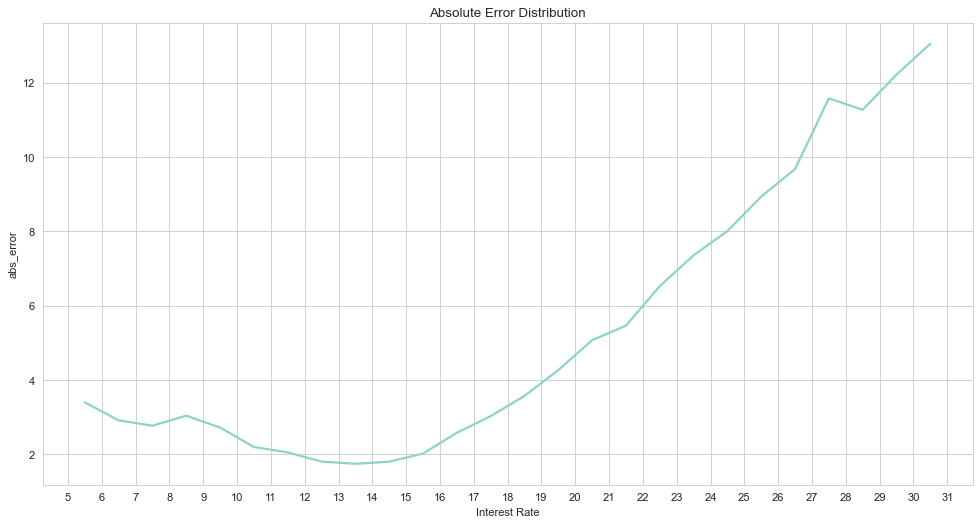

In [44]:
f.plot_error_distribution(
    y_true=int_data["y_test"],
    y_pred=int_best_xgb_model.predict(int_data["x_test"]),
    bins=np.linspace(0,35,36)
)
ax = plt.gca()
ax.set_xticks(np.linspace(5, 31, 27))
ax.set_xlabel("Interest Rate");

&nbsp;

## <a id='toc1_7_'></a>[Deployment](#toc0_)

The final step of the project is to deploy the models and run some predictions. 

The models have been uploaded to google cloud, but I'm running a local version as well for http requests.

&nbsp;

To run the deployment server, use the following command in the terminal:

`uvicorn src.lib.deployment:app --reload`

Now we can run the following cell to get a prediction.

To prevent errors when running all code cells, the cell below is set to markdown. Convert it to a code cell with the shortcut Y and feel free to run it.

In [ ]:
models = f.DEPLOYMENT_MODELS

# Choose the model to test
# Model 0: Approval classification linear regression model
# Model 1: Approval classification XGBoost model
# Model 2: Grade classification XGBoost model
# Model 3: Sub-grade classification XGBoost model
# Model 4: Interest rate regression XGBoost model
chosen_model = models[3]

with open(chosen_model["sample_path"]) as f:
    sample = json.load(f)
    response = requests.post( 
        "http://127.0.0.1:8000/predict",
        json={
            "model": chosen_model["model_path"],
            "parameters": sample[0]
        }
        )
        
    if response.status_code == 200: 
        prediction = response.json()["prediction"]
        if chosen_model["labels"] is not None:
            print(f"Prediction: {chosen_model['labels'][int(prediction)]}")
        else:
            print(f"Prediction: {prediction}")
        
            


&nbsp;

&nbsp;

---

## <a id='toc1_8_'></a>[Summary](#toc0_)

We've reached the end of the project, let's recap what was done.

We briefly analyzed the numerical columns that had correlations with the interest rate and used those to train models to predict both the interest rate and sub-grade of the loan.

We also uploaded the models to google cloud and deployed them locally to test predictions on each model.


## <a id='toc1_9_'></a>[Improvements](#toc0_)

As far as improvements, I think there are plenty that could be made if more time was available.

First of all, it was not specified which data could be used for predictions. If we were to talk to subject matter experts, I believe I may have made a mistake there. I used different features in part 1, part 2 and part 3. In retrospect, I'm thinking that maybe these models should all have been trained on the data present in part 1 during the application for the loan. This would also have made the project dramatically shorter. I'm curious to hear your opinion about this.

Second, I think that more feature exploration could be done in parts 2 and 3. Because of time constraints, I used the numerical features available and did not use categorical ones. Better performance might be possible by including certain categorical features. That ofcourse also depends on the answer to my previous question. Should all models be based on the data that's used to approve or decline the loan? If so, this improvement is invalid and the exploration in part 1 is sufficient.

Third, more boosting models could be tested using tools like optuna to find the best performing models, not just using XGBoost.

Thank you for going through this entire project with me. It's been quite a long one. I'm eager to hear your feedback.